In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [2]:
### Download the file
import pathlib
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)
path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [3]:
def load_data(path):
    text = path.read_text(encoding = 'utf-8')
    
    lines = text.splitlines()
    
    pairs = [line.split("\t") for line in lines]
    
    context = np.array([context for target, context in pairs])
    target = np.array([target for target,context in pairs])
    
    return target, context

In [4]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [5]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Creating dataset

In [6]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    
)

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)                    
)

In [7]:
for example_context_strings, exaple_target_context in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(exaple_target_context[:5])
    break

tf.Tensor(
[b'Te estoy tratando de ayudar.'
 b'\xc3\x89l dijo que ten\xc3\xadamos que guardar el secreto.'
 b'Tom gan\xc3\xb3 la apuesta.' b'Por favor no lo ponga en la mesa.'
 b'\xc3\x89l hizo lo que le instru\xc3\xad.'], shape=(5,), dtype=string)

tf.Tensor(
[b"I'm trying to help you." b'He said we must keep the secret.'
 b'Tom won the bet.' b"Please don't put it on the table."
 b'He did what I told him to do.'], shape=(5,), dtype=string)


### Text PreProcessing

One of the goals of this tutorial is to build a model that can be exported as a tf.saved_model. To make that exported model useful it should take tf.string inputs, and return tf.string outputs: All the text processing happens inside the model. Mainly using a layers.TextVectorization layer

**Standardization:**
The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The tensorflow_text package contains a unicode normalize operation:
    

In [8]:
example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


***Unicode normalization will be first step in the text Standardization function***


In [9]:
def tf_lower_and_split_punct(text):
    # split accented characters
    text = tf_text.normalize_utf8(text, "NFKD")
    text = tf.strings.lower(text)
    # keeps space, a to z, and select punctuation
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # add spaces around punctuation
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # strip whitespace.
    text = tf.strings.strip(text)
    
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [10]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


### Text Vectorization

This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [11]:
max_vocab_size = 5000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens = max_vocab_size,
    ragged=True
)

The **`TextVectorization`** layer and many other `Keras preprocessing layers` have an adapt method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This adapt method initializes the layer based on the data. Here it determines the vocabulary:

In [12]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# here are the first 10 words from the vocabulary
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

That's the Spanish **`TextVectorization`** layer, now build and `.adapt()` the English one:

In [13]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens = max_vocab_size,
    ragged=True
)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [14]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 30, 41, 1058, 6, 328, 4, 3],
 [2, 7, 93, 5, 1607, 5, 2775, 7, 521, 4, 3], [2, 10, 1101, 11, 1, 4, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [15]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] te estoy tratando de ayudar . [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

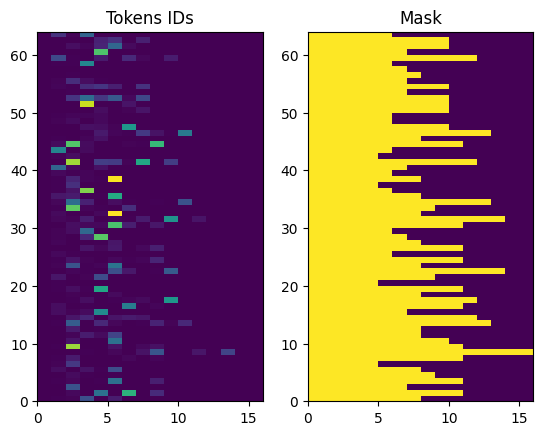

In [16]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Tokens IDs')

plt.subplot(1,2,2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title("Mask")

### process the dataset

The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs. It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit. Keras expects (inputs, labels) pairs, the inputs are the (context, target_in) and the labels are target_out. The difference between target_in and target_out is that they are shifted by one step relative to eachother, so that at each location the label is the next token.



In [17]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:, : -1].to_tensor()
    targ_out = target[:, 1:].to_tensor()
    return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [18]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[  2 291  10  19   1   4   3   0   0   0]

[ 2 80 34 19  9 19 65 61 17  4]
[80 34 19  9 19 65 61 17  4  3]


### The encoder/decoder

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word.

The original [left] contains a few extra connections that are intentionally omitted from this tutorial's model [right], as they are generally unnecessary, and difficult to implement. Those missing connections are:


    1. Feeding the state from the encoder's RNN to the decoder's RNN.
    2. Feeding the attention output back to the RNN's input.



In [19]:
units = 256

**The encoder:** The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

1. Takes a list of token IDs (from context_text_processor).
2. Looks up an embedding vector for each token (Using a layers.Embedding).
3. Processes the embeddings into a new sequence (Using a bidirectional layers.GRU).
4. Returns the processed sequence. This will be passed to the attention head.

In [65]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units
        
        # the embedding layer converts token to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                  mask_zero=True)
        
        # The RNN layer processes those vectors sequentially
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units, return_sequences=True,
                                     recurrent_initializer='glorot_uniform')
            
        )
    def call(self, x):

        
        x = self.embedding(x)
        
        x = self.rnn(x)
        
        return x
    def convert_inputs(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context
        

In [21]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, units)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 256)


In [22]:
ex_context_tok.shape

TensorShape([64, 20])

### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (layers.GlobalAveragePooling1D). An attention layer is similar, but calculates a weighted average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

### **Cross Attention:**
Cross-attention is a type of attention mechanism that allows one sequence of data (the "query") to focus on another sequence of data (the "context" or "key-value pairs"). It is commonly used in neural networks, particularly in Transformer architectures, to enable interaction between different sequences of data.

**key concepts:** 

1. `Query (Q):` The sequence for which we want to compute the attention scores. In cross-attention, this often represents the target sequence we want to predict or analyze.
2. `Key (K):` The sequence that is used to compute the attention scores. It helps in identifying how much focus each element of the query should give to each element of the context.
3. `Value (V):` The sequence that contains the actual values to be attended to, based on the computed attention scores from the query and key interaction.


**Mechanism of Cross-Attention:**

The cross-attention mechanism works by:

1. Computing the dot products between the queries and keys to get raw attention scores.
2. Scaling the attention scores by the square root of the key dimension to maintain stability.
3. Applying the softmax function to these scores to get normalized attention weights.
4. Using these attention weights to compute a weighted sum of the values, resulting in the attended output.



**Summary:**
Cross-attention is a mechanism that allows one sequence to focus on another sequence, enhancing the representation and understanding by incorporating relevant contextual information. It is a crucial component in various neural network architectures, particularly in Transformer models, enabling tasks like machine translation, text summarization, and multimodal learning.

**Example of use cases:** Machine Translation, Text summarization, image Captioning, Multimodal Learning. 

In [23]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores = True
        )
        
        attn_scores = tf.reduce_mean(attn_scores, axis=-1)
        self.last_attention_weights = attn_scores
        
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

In [24]:
attention_layer = CrossAttention(units)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), 
                                 output_dim=units, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)
result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 20, 256)
Target sequence, shape (batch, t, units): (64, 20, 256)
Attention result, shape (batch, t, units): (64, 20, 256)
Attention weights, shape (batch, t, s):    (64, 1, 20)


The attention weights will sum to 1 over the context sequence, at each location in the target sequence.

In [25]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.], dtype=float32)

### Decoder 

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.


When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.


When running inference with this model it produces one word at a time, and those are fed back into the model

In [26]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    
    self.vocab_size = text_processor.vocabulary_size()
    
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    
    self.start_token = self.word_to_id('[START]')
    
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)
        

### Training 

Next, the `call` method, takes 3 arguments:

1. `inputs` - a `context, x` pair where:
    * `context` - is the context from the encoder's output.
    * x - is the target sequence input.
        
2. `state `- Optional, the previous state output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
3. `return_state` - [Default: False] - Set this to True to return the RNN state.

In [27]:
@Decoder.add_method
def call(self,
        context, x,
        state=None,
        return_state=False):
    # lookup the embedding
    x = self.embedding(x)
    
    # Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    
    # Use the RNN output as the query for the attention over the contet
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    
    # Generate logit predictions for the next token
    logits = self.output_layer(x)
    
    if return_state:
        return logits, state
    else:
        return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [28]:
decoder = Decoder(target_text_processor, units)

In [29]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 20, 256)
input target tokens shape: (batch, t) (64, 20)
logits shape shape: (batch, target_vocabulary_size) (64, 20, 5000)


#### Inference 

To use it for inference you'll need a couple more methods

In [30]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [31]:
chars_to_id = tf.keras.layers.StringLookup(vocabulary=target_text_processor.get_vocabulary(),
                                          mask_token='', oov_token='[UNK]')
id_to_chars = tf.keras.layers.StringLookup(vocabulary=target_text_processor.get_vocabulary(),
                                          mask_token='', oov_token='[UNK]')

In [33]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

#### Explainnation:

the shape of context is: `[batch_size, sequence_length, vocab_size]`

1. tf.argmax(logits, axis=-1): it is used to select the token with highest probability for each time step across the `vocab size`. which is the intended to behaviour for selecteing most likely next token. token is nothing but a index of word. which we convert the word into index number by `text vecoriztion`. and we also do this here. we take the index of highest probability. then we can take word by `id_to_word` object. After this operation, output shape will be two which is `[batch_size, sequence_length]`.


2. The line `logits = logits[:, -1, :] / temperature` in the `else` section of the get_next_token function is used to implement sampling with temperature. This is a common technique to control the randomness and diversity of the generated sequence. 
    `Temperature scaling` is a technique used to adjust the probabilities produced by a model before sampling from them. It controls the "confidence" of the model's predictions.

    `logits[:, -1, :]:` This selects the logits for the last time step of each sequence in the batch.

    If logits has the shape `[batch_size, sequence_length, vocab_size]`, then `logits[:, -1, :]` will have the shape `[batch_size, vocab_size]`.

    **Why only last logits:** In sequence generation tasks, tokens are generated one at a time in a sequential manner. At each step, the model generates the next token based on the previously generated tokens and the context from the encoder. This means that at any given step, you are only concerned with predicting the next token, not multiple tokens simultaneously.

    During generation, at each time step, you only need the logits corresponding to the current prediction step. The last time step (-1) represents the logits for the current step where the next token needs to be predicted.



In [34]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature=0.0):
    logits, state = self(context, next_token, state=state, return_state=True)
    
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1,:]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)
    # If sequence produces an 'end token' set it 'done'
    done = done | (next_token == self.end_token)
    
    #Once a sequence is done it only  produces 0-padding
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
    
    return next_token, done, state

With those extra functions, you can write a generation loop:

In [35]:
# Setup the loop variables
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
    # Run one step
    next_token, done, state = decoder.get_next_token(
    ex_context, next_token, done, state, temperature=1.0)
    
    # add the token to the output
    tokens.append(next_token)
# Stack all the tokens together
tokens = tf.concat(tokens, axis=-1) # (batch t)

# convert the tokens back to a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'straight thinner slumped appreciated american mix ear speaks sent tomorrow',
       b'sauce breathe luck young wants reaction insane quick pretends stalling',
       b'cats pouring spend workaholic inspiration cab neither forgave chemical herself'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

### The Model

Now that you have all the model components, combine them to build the model for training:

In [36]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    def __init__(self, units,
               context_text_processor,
               target_text_processor):
        super().__init__()
        # build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)
        
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)
        
        #TODO(b/250038731): remove this
        try:
            del logits._keras_mask
        except AttributeError:
            pass
        return logits
    

During training the model will be used like this:

In [37]:
model = Translator(units, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 20)
Target tokens, shape: (batch, t) (64, 20)
logits, shape: (batch, t, target_vocabulary_size) (64, 20, 5000)


### Train
For training, you'll want to implement your own masked loss and accuracy functions:


In [38]:
def masked_loss(y_true, y_pred):
    # calculate the loss for each item in the batch
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)
    
    # mask offthe losses on the padding
    mask = tf.cast(y_true != 0, loss.dtype)
    
    loss *= mask
    
    # return the total
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)


In [39]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [40]:
# configure for training

model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [41]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

That should roughly match the values returned by running a few steps of evaluation:

In [42]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 11s 134ms/step - loss: 8.5244 - masked_acc: 9.1575e-05 - masked_loss: 8.5244


{'loss': 8.524397850036621,
 'masked_acc': 9.157509339274839e-05,
 'masked_loss': 8.524397850036621}

In [43]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 48s 350ms/step - loss: 5.0108 - masked_acc: 0.2639 - masked_loss: 5.0108 - val_loss: 4.0923 - val_masked_acc: 0.3577 - val_masked_loss: 4.0923
Epoch 2/100
100/100 [==============================] - 36s 356ms/step - loss: 3.6779 - masked_acc: 0.4060 - masked_loss: 3.6779 - val_loss: 3.3417 - val_masked_acc: 0.4475 - val_masked_loss: 3.3417
Epoch 3/100
100/100 [==============================] - 34s 342ms/step - loss: 3.1063 - masked_acc: 0.4791 - masked_loss: 3.1063 - val_loss: 2.8510 - val_masked_acc: 0.5203 - val_masked_loss: 2.8510
Epoch 4/100
100/100 [==============================] - 35s 351ms/step - loss: 2.6953 - masked_acc: 0.5434 - masked_loss: 2.6953 - val_loss: 2.5523 - val_masked_acc: 0.5595 - val_masked_loss: 2.5523
Epoch 5/100
100/100 [==============================] - 36s 356ms/step - loss: 2.3959 - masked_acc: 0.5813 - masked_loss: 2.3959 - val_loss: 2.2537 - val_masked_acc: 0.6003 - val_masked_loss: 2.2537
Epoch 6/10

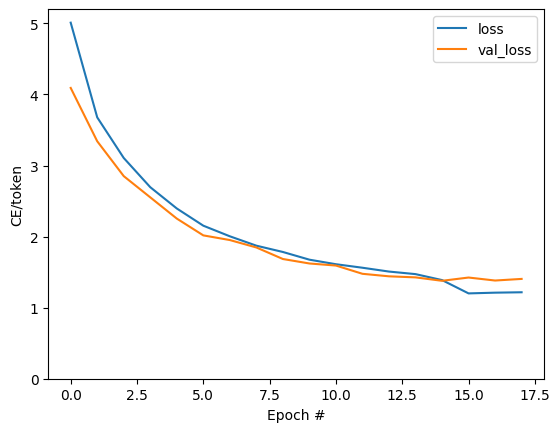

In [44]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

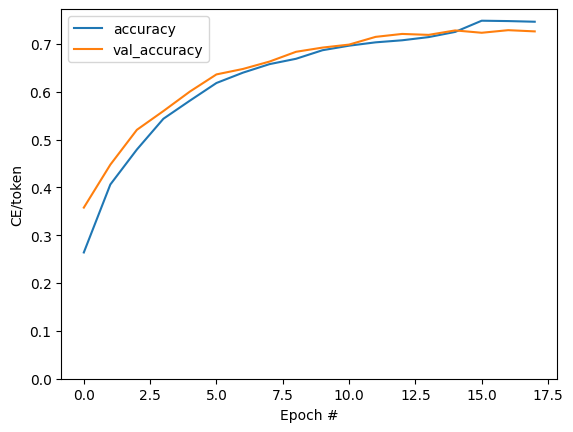

In [45]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

### Translate
Now that the model is trained, implement a function to execute the full text => text translation. This code is basically identical to the inference example in the decoder section, but this also captures the attention weights.

In [46]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_inputs(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result
            

In [66]:

#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

C:\Users\MASUM\AppData\Local\Temp\ipykernel_15424\2072787842.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\MASUM\AppData\Local\Temp\ipykernel_15424\2072787842.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


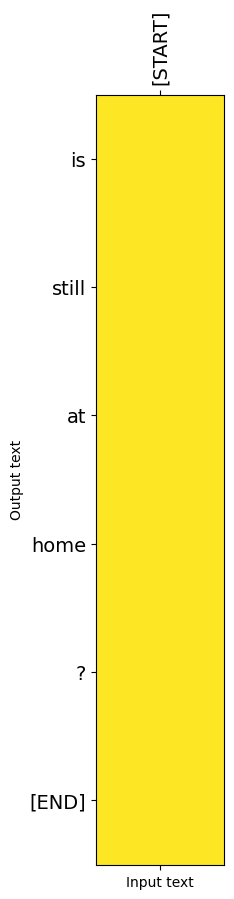

In [48]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

CPU times: total: 250 ms
Wall time: 262 ms


C:\Users\MASUM\AppData\Local\Temp\ipykernel_15424\2072787842.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\MASUM\AppData\Local\Temp\ipykernel_15424\2072787842.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


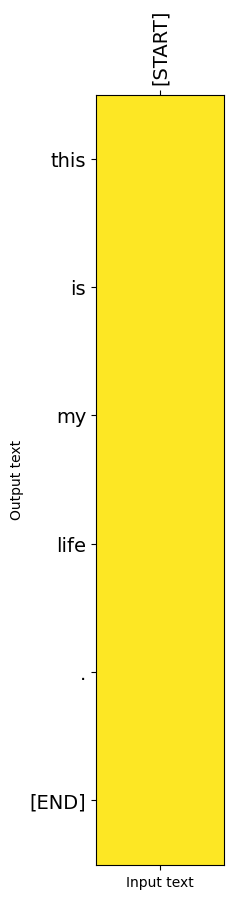

In [49]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

CPU times: total: 266 ms
Wall time: 259 ms


C:\Users\MASUM\AppData\Local\Temp\ipykernel_15424\2072787842.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\MASUM\AppData\Local\Temp\ipykernel_15424\2072787842.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


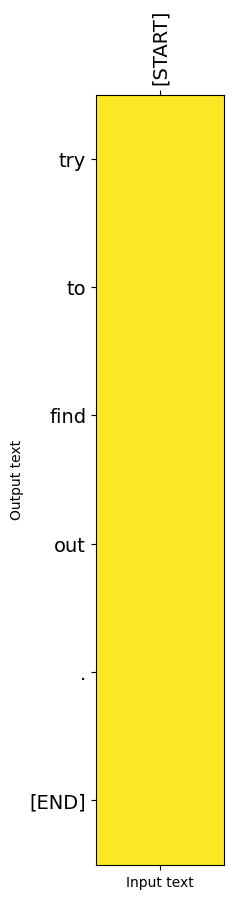

In [50]:
%%time
 # Try to find out.'
model.plot_attention('Tratar de descubrir.')


The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions

In [52]:
long_text = context_raw[-1]

import textwrap

print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


C:\Users\MASUM\AppData\Local\Temp\ipykernel_15424\2072787842.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\MASUM\AppData\Local\Temp\ipykernel_15424\2072787842.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


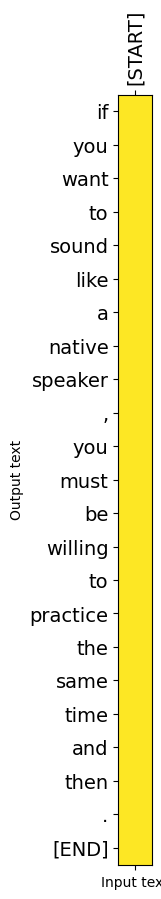

In [53]:
model.plot_attention(long_text)

The `translate function` works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time

In [54]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [56]:
%%time
for t in inputs:
    print(model.translate([t])[0].numpy().decode())

its very cold here . 
this is my life . 
his room is a [UNK] . 
CPU times: total: 1.53 s
Wall time: 1.54 s


In [57]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
his room is a [UNK] . 

CPU times: total: 656 ms
Wall time: 588 ms


### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job do

In [58]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.translate(inputs)

In [59]:
export = Export(model)

In [60]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a [UNK] .                                            

CPU times: total: 2min 25s
Wall time: 2min 25s


Now that the function has been traced it can be exported using `saved_model.save`

In [62]:
tf.saved_model.save(export, 'translator', signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: translator\assets


INFO:tensorflow:Assets written to: translator\assets


In [63]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) 

CPU times: total: 2min 37s
Wall time: 2min 37s


In [64]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
his room is a [UNK] .                                            

CPU times: total: 1.06 s
Wall time: 605 ms
